In [1]:
import os
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import string
from nltk.corpus import words
import mlflow
import mlflow.sklearn
import mlflow.keras
import sklearn.metrics
from mlflow.models.signature import infer_signature
from sklearn.model_selection import GridSearchCV
import re
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import auc as auc_score_func
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import spacy
import gensim
nlp = spacy.load('en_core_web_lg')
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def load_data():
    column_names = ["target", "ids", "date", "flag", "user", "text"]
    df = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv", names=column_names, encoding='latin1')
    display(df)
    return df

df = load_data()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School to...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you a..."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Analyse des données

In [4]:
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64

target    0.0
ids       0.0
date      0.0
flag      0.0
user      0.0
text      0.0
dtype: float64
Nombres de tweets dupliqués :  18534
col = target -> duplicated = 1599998
col = ids -> duplicated = 1685
col = date -> duplicated = 825637
col = flag -> duplicated = 1599999
col = user -> duplicated = 940225
col = text -> duplicated = 18534


0          False
1          False
2          False
3          False
4          False
           ...  
1599995    False
1599996    False
1599997    False
1599998    False
1599999    False
Name: text, Length: 1600000, dtype: bool


,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


,date,flag,user,text
count,1600000,1600000,1600000,1600000
unique,774363,1,659775,1581466
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1600000,549,210


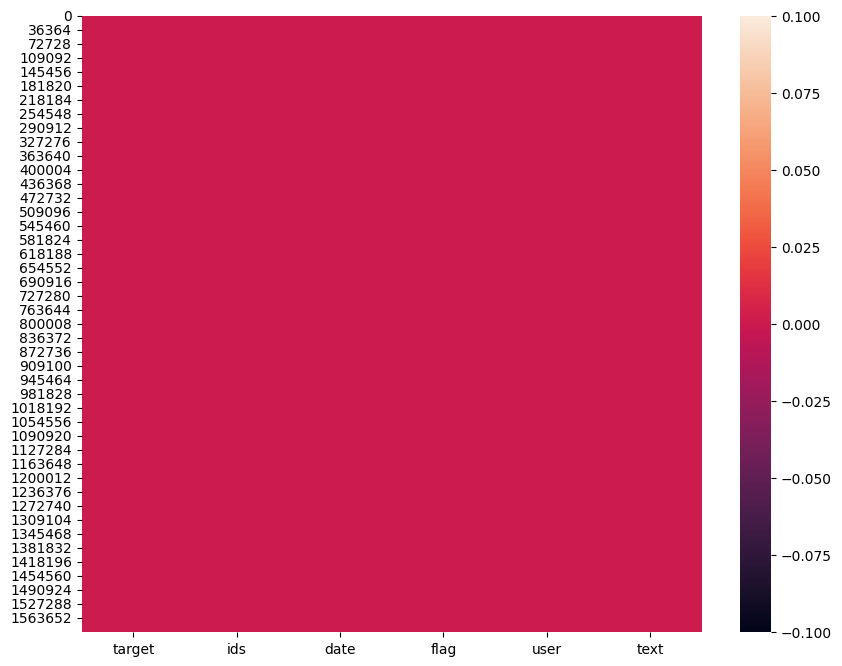

In [5]:
def analyse_data(data):
    """
    Analyse un DataFrame en affichant le pourcentage de valeurs manquantes, une heatmap des valeurs manquantes,
    le nombre de doublons pour l'ensemble du DataFrame et par colonne. Affiche également des statistiques
    descriptives pour les colonnes numériques et non numériques.

    Args:
        data (pandas.DataFrame): DataFrame à analyser.

    Returns:
        None. Cette fonction affiche directement les informations et les graphiques.
    """
    print(data.isna().mean().sort_values())
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.isna())
    print("Nombres de tweets dupliqués : ", data.text.duplicated().sum())
    for col in data.columns:
        n = data[col].duplicated().sum()
        print(f"col = {col} -> duplicated = {n}")
    print("\n")
    print(data.text.duplicated(keep="first"))
    idx = data.text.duplicated(keep="first")
    data.loc[idx, :].sort_values("text").head(10)
    display(data.describe(include=np.number))
    display(data.describe(include=object))

analyse_data(df)

Text(0.5, 1.0, 'Distribution du nombre de caractères des tweets')

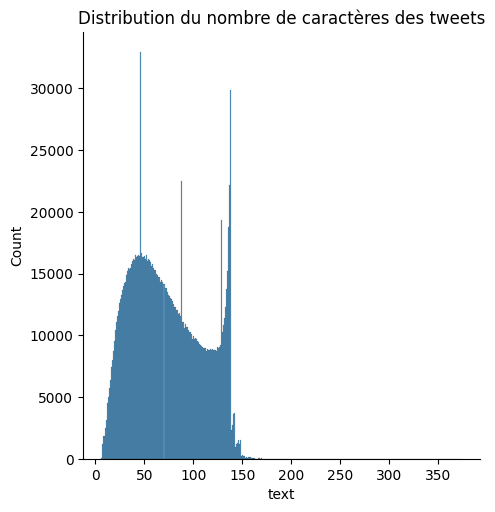

In [6]:
tmp = df.text.str.len()
sns.displot(tmp)
plt.title("Distribution du nombre de caractères des tweets")

In [7]:
tmp.sort_values(ascending=False)

1295281    374
1484882    369
380539     359
1582941    359
650945     348
          ... 
1071086      6
1229947      6
4233         6
310554       6
1050599      6
Name: text, Length: 1600000, dtype: int64

In [8]:
def drop_columns(df):
    df = df[['target', 'text']]
    return df

def drop_text_duplicate(df):
    df = df.drop_duplicates(subset="text")
    return df

def filter_tweet(df):
    df['text'] = df['text'].str.strip()
    filtered_df = df[df['text'].str.match('^@[A-Za-z][A-Za-z0-9_]{0,14}$')]
    df = df.drop(filtered_df.index, axis= 0)
    display(filtered_df.head(20))
    print(f"Nombre de tweets non informatif supprimés : {filtered_df.shape[0]}")
    return df

df = drop_columns(df)
df = drop_text_duplicate(df)
df = filter_tweet(df)

,target,text
208,0,@mandayyy
249,0,@mandayyy
398,0,@danadearmond
430,0,@anistorm
1011,0,@citizensheep
1014,0,@GirlsGoneChild
1231,0,@thecoolestout
1421,0,@marlonjenglish
1486,0,@oishiieats
1641,0,@thisisguan


Nombre de tweets non informatif supprimés : 2482


In [9]:
def create_sample(df, n_sample):
    negative_tweets = df[df.iloc[:, 0] == 0]
    negative_tweets = negative_tweets.sample(n = n_sample, random_state=0)
    positive_tweets = df[df.iloc[:, 0] == 4]
    positive_tweets['target'] = positive_tweets['target'].replace({4:1})
    positive_tweets = positive_tweets.sample(n = n_sample, random_state=0)
    df_sample = pd.concat([negative_tweets, positive_tweets], ignore_index=True)
    return df_sample
df_sample = create_sample(df, 25_000)

C:\Users\aurel\AppData\Local\Temp\ipykernel_14308\2204551965.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_tweets['target'] = positive_tweets['target'].replace({4:1})


In [10]:
df_sample.target.value_counts(normalize=True)

target
0    0.5
1    0.5
Name: proportion, dtype: float64

In [11]:
def display_tokens_info(tokens):
    """display info about corpus"""
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])
eng_words = nltk.corpus.words.words()
display_tokens_info(eng_words)

nb tokens 236736, nb tokens uniques 235892
['A', 'a', 'aa', 'aal', 'aalii', 'aam', 'Aani', 'aardvark', 'aardwolf', 'Aaron', 'Aaronic', 'Aaronical', 'Aaronite', 'Aaronitic', 'Aaru', 'Ab', 'aba', 'Ababdeh', 'Ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


In [12]:
ps = nltk.PorterStemmer()
eng_words_stem = [ps.stem(i) for i in eng_words]
display_tokens_info(eng_words_stem)

nb tokens 236736, nb tokens uniques 178311
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaron', 'aaron', 'aaronit', 'aaronit', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abac', 'abacay', 'abacin', 'abacin', 'abaciscu', 'abacist', 'aback', 'abactin', 'abactin']


In [13]:
lm = nltk.WordNetLemmatizer()
eng_words_lem = [lm.lemmatize(i) for i in eng_words]
display_tokens_info(eng_words_lem)

nb tokens 236736, nb tokens uniques 235068
['A', 'a', 'aa', 'aal', 'aalii', 'aam', 'Aani', 'aardvark', 'aardwolf', 'Aaron', 'Aaronic', 'Aaronical', 'Aaronite', 'Aaronitic', 'Aaru', 'Ab', 'aba', 'Ababdeh', 'Ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


In [14]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [15]:
"""
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
"""

"\nnltk.download('omw-1.4')\nnltk.download('wordnet')\nnltk.download('stopwords')\nnltk.download('words')\n"

In [16]:
texts = [
    "Net income was $9.4 million compared to the prior year of $2.7 million.",
    "Revenue exceeded twelve billion dollars, with a loss of $1b.",
]

for doc in nlp.pipe(texts, disable=['parser', 'ner', 'textcat']):
    tokens_lem = [tok.lemma_.strip() for tok in doc]
    print("Tokens lemmatisés : ", tokens_lem)

Tokens lemmatisés :  ['net', 'income', 'be', '$', '9.4', 'million', 'compare', 'to', 'the', 'prior', 'year', 'of', '$', '2.7', 'million', '.']
Tokens lemmatisés :  ['revenue', 'exceed', 'twelve', 'billion', 'dollar', ',', 'with', 'a', 'loss', 'of', '$', '1b', '.']


In [17]:
def clean_docs(texts, remove_stopwords=False, lemmatize=False, stem=False, n_process=6):
    if lemmatize and stem:
        raise ValueError("Un seul transformateur peut être appliqué.")
        
    def clean_text(text):
        text = re.sub(r'@[A-Za-z0-9]+'," ",text)
        text = re.sub(r'https?://[A-Za-z0-9./]+'," ",text) 
        text = text.lower()
        text = re.sub(r"&quot", "", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = text.replace("won't", "will not")
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"\'scuse", " excuse ", text)
        text = text.replace("€", " euro ").replace("$", " dollar ").replace("%", " percent ")
        text = text.replace("cant", "cannot ").replace("cannot", "can not").replace("can't", "can not")
        text = text.replace("don't", "do not").replace("dont", "did not").replace("didn't", "did not").replace(" im "," i am ").replace(" it's", "it is")
        text = text.replace("n't", " not").replace("what's", "what is")
        text = text.replace("he's", "he is").replace(" she's", "she is").replace("'s", " own")
        translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
        text = text.translate(translator)
        text = re.sub(r' +'," ",text)
        return text

    # Clean the texts
    texts = [clean_text(text) for text in texts]
    
    docs = nlp.pipe(texts, n_process=n_process, disable=['parser', 'ner', 'textcat'])
    stopwords = set(nltk.corpus.stopwords.words('english'))
    stemmer = nltk.PorterStemmer()

    docs_cleaned = []
    for doc in docs:
        if lemmatize:
            tokens = [tok.lemma_.strip() for tok in doc]
        elif stem:
            tokens = [stemmer.stem(tok.text.strip()) for tok in doc]
        else:
            tokens = [tok.text.strip() for tok in doc]

        if remove_stopwords:
            tokens = [tok for tok in tokens if tok not in stopwords]

        tokens = [w for w in tokens if len(w) >= 2]

        doc_clean = ' '.join(tokens)
        docs_cleaned.append(doc_clean)

    return docs_cleaned

class SpacyTextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, remove_stopwords=False, lemmatize=False, stem=False, n_process=4):
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.stem = stem
        self.n_process = n_process

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return clean_docs(X, self.remove_stopwords, self.lemmatize, self.stem, self.n_process)

df_sample['clean_text_lem'] = clean_docs(df_sample['text'], remove_stopwords=True ,lemmatize=True)
df_sample['clean_text_stem'] = clean_docs(df_sample['text'], remove_stopwords=True , stem=True)

In [18]:
df_sample.head(30)

,target,text,clean_text_lem,clean_text_stem
0,0,Everything around reminds me of you,everything around remind,everyth around remind
1,0,Just disappointed sometimes you do something nice and it just goes unnoticed,disappointed sometimes something nice go unnoticed,disappoint sometim someth nice goe unnot
2,0,"@squidgy15 ahaha. OH NO! FOXTEL SAID WE CANT HAVE DISNEY CHANNEL ANYMORE, SO I'M MISSING JONAS!",ahaha oh foxtel say disney channel anymore miss jona,ahaha oh foxtel said disney channel anymor miss jona
3,0,"@JHornberg system overload, plus exposition park has poor service for Tmo/Verizon/AT&amp;T. Only...",system overload plus exposition park poor service tmo verizon amp one friend could call,system overload plu exposit park ha poor servic tmo verizon amp onli one friend could call
4,0,i hope the indians game doesnt get rained out,hope indians game get rain,hope indian game doe nt get rain
5,0,"Good news this morning.Wish I was as excited as everyone else Will happen, has to happen, waite...",good news morning wish excited everyone else happen happen wait mo make em proud,good news thi morn wish wa excit everyon els happen ha happen wait mo make em proud
6,0,In Duluth in traffic...not fun,duluth traffic fun,duluth traffic fun
7,0,@LeeAnnAnderson @Hot4Donnie knight girls.. my headache is back,knight girl headache back,knight girl headach back
8,0,time for bed. still bummed my tv's busted. i guess no late night E! before bed,time bed still bum tv bust guess late night bed,time bed still bum tv bust guess late night befor bed
9,0,The Beatles said &quot;almost finished&quot; with New Orleans!,beatle say almost finish new orleans,beatl said almost finish new orlean


In [19]:
empty_tweets = df_sample.loc[df_sample["clean_text_lem"] == ""]
display(empty_tweets)
print(f"Nombres de tweets vides après Lemmatisation : {empty_tweets.shape[0]}")

,target,text,clean_text_lem,clean_text_stem
1188,0,@supmanda http://www.kwod.net/index.php this is why,,thi whi
1565,0,@iamepiclyamazin but....why?!,,whi
2096,0,@haemoglobin_ Why?,,whi
2235,0,@trevslovelyface @cantfoolowls http://bit.ly/jIVH4,,
2259,0,@simzawastaken it is so...,,
...,...,...,...,...
49161,1,@MisterPlow What have I done now?,,done
49279,1,here i am!,,
49302,1,@nitesofsuburbia that's SO YOU!,,
49395,1,@Green4GoodDavid same to you!,,


Nombres de tweets vides après Lemmatisation : 139


On remarque qu'en supprimant les stopwords, certains tweets se retrouvent vides après lemmatisation

In [33]:
def train_valid_test_split(X, y, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=0):
    if train_size + valid_size + test_size != 1.0:
        raise ValueError("Les proportions ne s'additionnent pas à 1.0")

    # divisez vos données en un ensemble d'apprentissage et un ensemble temporaire
    X_train, X_temp, y_train, y_temp = train_test_split(X,
                                                        y,
                                                        stratify=y,
                                                        test_size=1-train_size,
                                                        random_state=random_state)

    # calculer la taille relative des ensembles de validation et de test
    relative_test_size = test_size / (valid_size + test_size)

    # divisez l'ensemble temporaire en ensembles de validation et de test
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp,
                                                        stratify=y_temp,
                                                        test_size=relative_test_size,
                                                        random_state=random_state)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [21]:
def calcul_metrics(y_valid, y_valid_pred ,title, recover = False):
    #Ajouter le score ACCURACY
    print(title)
    print(classification_report(y_valid, y_valid_pred))
    accuracy = accuracy_score(y_valid, y_valid_pred)
    print("Accuracy score :", accuracy)
    precision = precision_score(y_valid, y_valid_pred)
    print("Precision Score :", precision)
    recall = recall_score(y_valid, y_valid_pred)
    print("Recall Score :", recall)
    f1 = f1_score(y_valid, y_valid_pred)
    print("F1 Score :", f1)
    fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred)
    score_auc = auc_score_func(fpr, tpr)
    print("AUC :" , score_auc, "\n")
    if recover:
        return accuracy, precision, recall, f1, score_auc

## Regression Logistique

### BoW

In [22]:
%%time
mlflow.set_tracking_uri('file://' + os.path.abspath('mlruns'))
experiment_name = "Regression Logistique"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="TFIDF run"):
    params = {"penalty": "l2", "C": 1.0, "random_state": 0}
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(remove_stopwords=False, stem=True)),
        ('vect', TfidfVectorizer()),
        ('clf', LogisticRegression(**params))
    ])
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(df_sample['text'] ,df_sample['target'])
    pipeline.fit(X_train, y_train)
    y_valid_pred = pipeline.predict(X_valid)
    accuracy, precision, recall, f1, score_auc = calcul_metrics(y_valid, y_valid_pred, "Performances sur le validation set avec Stemming et TF-IDF", recover=True)
    mlflow.log_param("preprocessing", "Stemming et TF-IDF")
    mlflow.log_params(params)
    mlflow.log_metrics({
    "accuracy_score": accuracy,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    })
    signature = infer_signature(X_valid, y_valid_pred)
    mlflow.sklearn.log_model(
        sk_model=pipeline.named_steps['clf'],
        artifact_path="tf-idf",
        signature=signature,
        registered_model_name="tf-idf",
    )

Performances sur le validation set avec Stemming et TF-IDF
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      2500
           1       0.76      0.76      0.76      2500

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000

Accuracy score : 0.7604
Precision Score : 0.7597765363128491
Recall Score : 0.7616
F1 Score : 0.7606871753895325
AUC : 0.7604 



C:\Users\aurel\anaconda3\envs\env_p7\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'tf-idf' already exists. Creating a new version of this model...
2023/06/30 00:42:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: tf-idf, version 9


CPU times: total: 30.1 s
Wall time: 1min 33s


Created version '9' of model 'tf-idf'.


In [23]:
%%time
pipeline.set_params(clean_text__stem=False, clean_text__lemmatize=True)
pipeline.fit(X_train, y_train)
y_valid_pred = pipeline.predict(X_valid)
calcul_metrics(y_valid, y_valid_pred, "Performances sur le validation set avec Lemmatisation et TF-IDF :")

Performances sur le validation set avec Lemmatisation et TF-IDF :
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      2500
           1       0.76      0.76      0.76      2500

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000

Accuracy score : 0.7574
Precision Score : 0.7552558508528362
Recall Score : 0.7616
F1 Score : 0.7584146584345748
AUC : 0.7574 

CPU times: total: 21.6 s
Wall time: 1min 21s


### Word embedding (Spacy pré entrainé)

In [24]:
class SpacyVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([self.nlp(text).vector for text in X])

In [25]:
%%time
with mlflow.start_run(run_name="Word Embedding run"):
    params = {"penalty": "l2", "C": 1.0, "random_state": 0}

    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(remove_stopwords=False, lemmatize=True)),
        ('embedding', SpacyVectorizer(nlp)),
        ('clf', LogisticRegression(**params))
    ])
    pipeline.fit(X_train, y_train)
    y_valid_pred = pipeline.predict(X_valid)

    accuracy, precision, recall, f1, score_auc = calcul_metrics(y_valid, y_valid_pred, "Performances sur le validation set avec Lemmatisation et Spacy", recover=True)
    mlflow.log_param("preprocessing", "Lemmatization et Spacy")
    mlflow.log_params(params)
    mlflow.log_metrics({
    "accuracy_score": accuracy,
    "precision_score": precision,
    "recall_score": recall,
    "f1_score": f1,
    "auc": score_auc,
    })
    signature = infer_signature(X_valid, y_valid_pred)
    mlflow.sklearn.log_model(
        sk_model=pipeline.named_steps['clf'],
        artifact_path="spacy",
        signature=signature,
        registered_model_name="spacy",
    )

C:\Users\aurel\anaconda3\envs\env_p7\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Performances sur le validation set avec Lemmatisation et Spacy
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      2500
           1       0.74      0.74      0.74      2500

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000

Accuracy score : 0.7418
Precision Score : 0.7430639324487334
Recall Score : 0.7392
F1 Score : 0.7411269300180469
AUC : 0.7417999999999999 



Registered model 'spacy' already exists. Creating a new version of this model...
2023/06/30 00:48:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: spacy, version 9


CPU times: total: 2min 22s
Wall time: 4min 15s


Created version '9' of model 'spacy'.


In [26]:
# %%time
# parameters = {
#     'vect__max_df': [0.9, 1.0],
#     'vect__min_df': [1, 3],
#     'vect__ngram_range': [(1, 1), (1, 2)],
#     'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],
#     'clf__penalty':['l1', 'l2'],
#     'clf__C':[0.1, 1]}

# pipeline = Pipeline([
#         ('clean_text', SpacyTextCleaner(remove_stopwords=True, stem=True)),
#         ('vect', TfidfVectorizer()),
#         ('clf', LogisticRegression(random_state=0))
#     ])

# grid_search = GridSearchCV(pipeline, parameters, cv=10, scoring='accuracy', verbose=2, n_jobs=6)

# with mlflow.start_run(run_name="GridSearchCV run"):
#     grid_search.fit(X_train, y_train)

#     mlflow.log_param("C", grid_search.best_params_['clf__C'])
#     mlflow.log_param("penalty", grid_search.best_params_['clf__penalty'])
#     mlflow.log_param("solver", grid_search.best_params_['clf__solver'])

#     y_valid_pred = grid_search.predict(X_valid)
#     accuracy_valid_set, precision_valid_set, recall_valid_set, f1_valid_set, auc_score_valid_set = calcul_metrics(y_valid, y_valid_pred, "Performances sur le validation set avec Lemmatisation, Word2Vec et GridSearch", recover=True)
#     y_test_pred = grid_search.predict(X_test)
#     accuracy_test_set, precision_test_set, recall_test_set, f1_test_set, auc_score_test_set = calcul_metrics(y_test, y_test_pred, "Performances sur le test set avec Lemmatisation, Word2Vec et GridSearch", recover=True)
#     mlflow.log_metrics({
#         "valid_accuracy_score": accuracy_valid_set,
#         "valid_precision_score": precision_valid_set,
#         "valid_recall_score": recall_valid_set,
#         "valid_f1_score": f1_valid_set,
#         "valid_auc": auc_score_valid_set,
#     })
#     mlflow.log_metrics({
#     "test_accuracy_score": accuracy_test_set,
#     "test_precision_score": precision_test_set,
#     "test_recall_score": recall_test_set,
#     "test_f1_score": f1_test_set,
#     "test_auc": auc_score_test_set,
#     })
#     signature = infer_signature(X_test, y_test_pred)
#     mlflow.sklearn.log_model(
#         sk_model=grid_search.best_estimator_,
#         artifact_path="GridSearchCV",
#         signature=signature,
#         registered_model_name="GridSearchCV",
#     )

## Modèle simple avec Keras

In [27]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(df_sample['text'], df_sample['target'])
X_train_preprocessed = clean_docs(X_train, remove_stopwords=False ,lemmatize=True)
words = [word for sentence in X_train_preprocessed for word in sentence.split()]
nb_words = len(set(words))
display_tokens_info(words)

nb tokens 480066, nb tokens uniques 28393
['love', 'how', 'everyone', 'here', 'be', 'work', 'and', 'just', 'sit', 'on', 'the', 'swing', 'take', 'picture', 'lol', 'no', 'more', 'exam', 'leave', 'wow', 'before', 'the', 'storm', 'make', 'cry', 'like', 'cry', 'right', 'now', 'it']


In [28]:
max_len_tweet = max(X_train_preprocessed, key=lambda tweet: len(tweet.split()))
print("Le tweet le plus long est :", max_len_tweet)
print("Il contient", len(max_len_tweet.split()), "mots.")

Le tweet le plus long est : right be off to do some house work ill be about 20 min as do most of it earliar so all ve get to do be do the kitchen and hoover up
Il contient 32 mots.


16040 tokens uniques pour 20000 tweets semble beaucoup

In [37]:
def prepare_keras_data(docs):
    words = [word for sentence in docs for word in sentence.split()]
    nb_words = len(set(words))
    tokenizer = Tokenizer(nb_words=nb_words)
    tokenizer.fit_on_texts(docs)
    encoded_docs = tokenizer.texts_to_sequences(docs)
    padded_docs = pad_sequences(encoded_docs)
    return padded_docs, nb_words

In [45]:
%%time
experiment_name = "Keras model"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="Keras run"):
    
    embed_dim = 32
    batch_size = 64
    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(remove_stopwords=False, lemmatize=True)),
    ])
    
    df_sample_clean = pipeline.transform(df_sample['text'])
    X, nb_words = prepare_keras_data(df_sample_clean)
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, df_sample['target']) 

    
    model = Sequential()
    model.add(Embedding(input_dim=nb_words , output_dim=embed_dim, input_length=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))  
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=4)
    
    hist = model.fit(
        X_train, 
        y_train, 
        epochs=30, 
        batch_size=64, 
        validation_data=(X_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )

    
    input_example = X_valid[:5]
    output_example = model.predict(input_example)
    signature = infer_signature(input_example, output_example)
   
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
    mlflow.log_metrics({
    "test_accuracy_score": scores[1] * 100,
#     "test_precision_score": precision_test_set,
#     "test_recall_score": recall_test_set,
#     "test_f1_score": f1_test_set,
#     "test_auc": auc_score_test_set,
    })
    mlflow.keras.log_model(
    model,
    artifact_path="Keras",
    registered_model_name="Keras",
    signature = signature
)

C:\Users\aurel\anaconda3\envs\env_p7\lib\site-packages\keras\preprocessing\text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 32, 32)            1044320   
                                                                 
 dropout_5 (Dropout)         (None, 32, 32)            0         
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 16)                16400     
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dropout_7 (Dropout)         (None, 16)               

Registered model 'Keras' already exists. Creating a new version of this model...
2023/06/30 01:43:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Keras, version 24


CPU times: total: 21.6 s
Wall time: 1min 13s


Created version '24' of model 'Keras'.


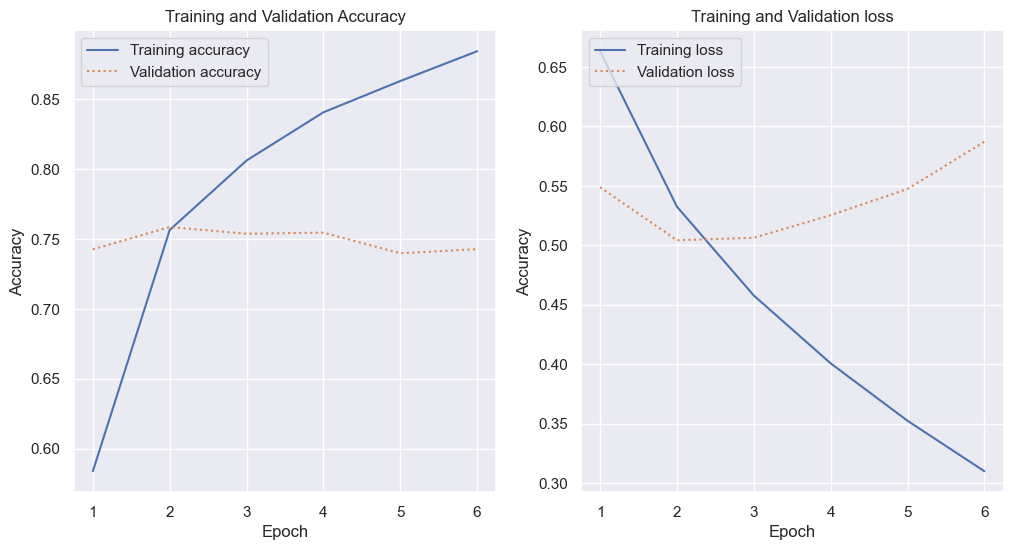

In [46]:
def plot_hist(hist):
    sns.set()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, '-', label='Training accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    plt.subplot(1, 2, 2)
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss, '-', label='Training loss')
    plt.plot(epochs, val_loss, ':', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    
plot_hist(hist)

## Modèle LSTM

C:\Users\aurel\anaconda3\envs\env_p7\lib\site-packages\keras\preprocessing\text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 32, 64)            2088640   
                                                                 
 dropout_9 (Dropout)         (None, 32, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               66000     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 2,154,741
Trainable params: 2,154,741
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1250/1250 [==============================] - 87s 69ms/step - loss: 0.5321 - accuracy: 0.7325 - val_loss: 0.4944 - val_accuracy: 0.7606
Epoch 2/30
1250/1250 [===

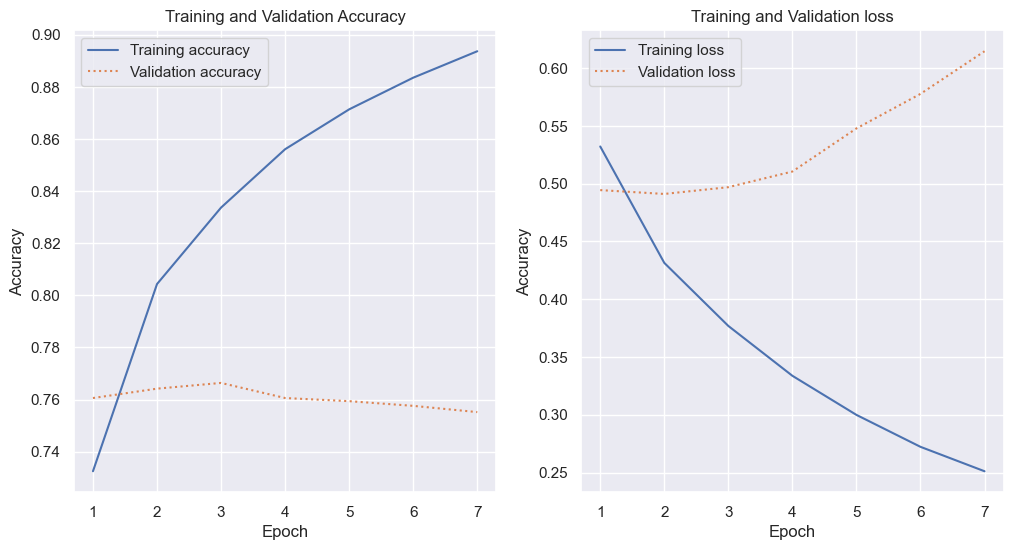

In [48]:
experiment_name = "LSTM model"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name="LSTM run"):
    
    embed_dim = 64
    lstm_out = 100
    batch_size = 32
    
    pipeline = Pipeline([
        ('clean_text', SpacyTextCleaner(remove_stopwords=False, lemmatize=True)),
    ])

    df_sample_clean = pipeline.transform(df_sample['text'])
    X, nb_words = prepare_keras_data(df_sample_clean)
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, df_sample['target'])
    
    model = Sequential()
    model.add(Embedding(input_dim=nb_words , output_dim=embed_dim, input_length=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=4)
    
    hist = model.fit(
        X_train, 
        y_train, 
        epochs=30, 
        batch_size=batch_size, 
        validation_data=(X_valid, y_valid), 
        callbacks=[early_stopping], 
        verbose=1
    )
    
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy on test data: %.2f%%" % (scores[1] * 100))
    
plot_hist(hist)